In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
data_dir = './coe379L-sp25/datasets/unit03/Project3'
damage_path = os.path.join(data_dir, 'damage')
no_damage_path = os.path.join(data_dir, 'no_damage')

In [4]:
damage_count = len(os.listdir(damage_path))
no_damage_count = len(os.listdir(no_damage_path))

In [5]:
#print data set size
print(f"Damage images: {damage_count}")
print(f"No damage images: {no_damage_count}")

Damage images: 14170
No damage images: 7152


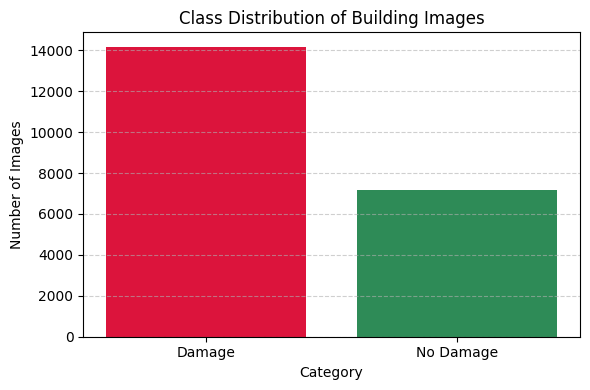

In [6]:
#class distribution bar chart
plt.figure(figsize=(6, 4))
plt.bar(['Damage', 'No Damage'], [damage_count, no_damage_count], color=['crimson', 'seagreen'])
plt.title("Class Distribution of Building Images")
plt.ylabel("Number of Images")
plt.xlabel("Category")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [7]:
## Dataset includes X damaged and Y non-damaged building images.
# Class distribution is [balanced / slightly imbalanced], which will affect model sensitivity and recall if not addressed.


In [8]:
#visual inspection for data quality
#gpt help here
def show_sample_images(folder_path, title, num_images=5):
    sample_files = random.sample(os.listdir(folder_path), num_images)
    plt.figure(figsize=(15, 3))
    for i, file in enumerate(sample_files):
        img = Image.open(os.path.join(folder_path, file))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.tight_layout()
    plt.show()

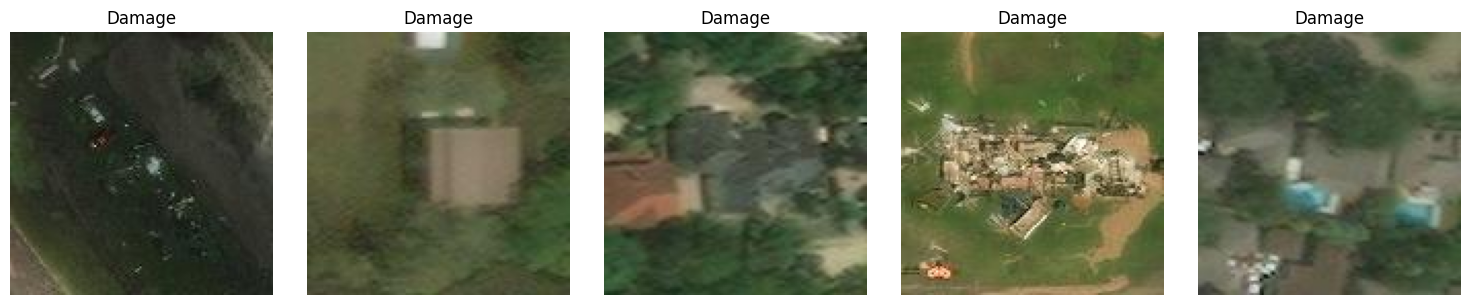

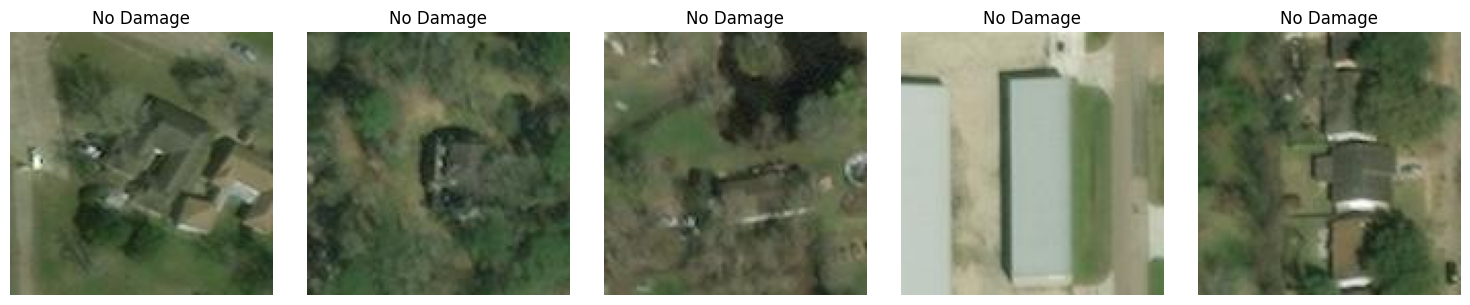

In [9]:
show_sample_images(damage_path, 'Damage')
show_sample_images(no_damage_path, 'No Damage')

In [10]:
# The images vary in orientation, lighting, and resolution.
# Some are blurry or obscured, which may impact model performance.

In [11]:
#image attributes

In [12]:
sample_image_path = os.path.join(damage_path, os.listdir(damage_path)[0])
img = Image.open(sample_image_path)

In [13]:
#inspect sample image

In [14]:
print("Sample image shape:", img.size)
print("Image mode:", img.mode)

Sample image shape: (128, 128)
Image mode: RGB


In [15]:
#all images are RGBand will be resized to a fixed shape for consistency.
# don't really see corrupted files in this sample

In [16]:
# Consistent input shape for neural networks

In [17]:
img_size = (128, 128) 

In [18]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2  # 80% train / 20% validation
)

In [19]:
#gpt help for this one
train_gen = datagen.flow_from_directory(
    directory=data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 17058 images belonging to 2 classes.


In [20]:
val_gen = datagen.flow_from_directory(
    directory=data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 4264 images belonging to 2 classes.


In [21]:
X_batch, y_batch = next(train_gen)
print("Image batch shape:", X_batch.shape)
print("Label batch shape:", y_batch.shape)

Image batch shape: (32, 128, 128, 3)
Label batch shape: (32,)


In [22]:
#from alternate-Lenet-5 CNN architecture

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
input_shape = (128, 128, 3)

In [25]:
dense_model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [26]:
#gpt help

dense_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [27]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('dense_best.h5', save_best_only=True)
]

In [28]:
history_dense = dense_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
534/534 [==============================] - ETA: 0s - loss: 1.0284 - accuracy: 0.6365

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


534/534 [==============================] - 89s 165ms/step - loss: 1.0284 - accuracy: 0.6365 - val_loss: 0.6380 - val_accuracy: 0.6646
Epoch 2/30
534/534 [==============================] - 84s 157ms/step - loss: 0.6382 - accuracy: 0.6646 - val_loss: 0.6380 - val_accuracy: 0.6646
Epoch 3/30
534/534 [==============================] - 83s 156ms/step - loss: 0.6383 - accuracy: 0.6646 - val_loss: 0.6384 - val_accuracy: 0.6646
Epoch 4/30
534/534 [==============================] - 85s 160ms/step - loss: 0.6383 - accuracy: 0.6646 - val_loss: 0.6380 - val_accuracy: 0.6646
Epoch 5/30
534/534 [==============================] - 85s 158ms/step - loss: 0.6383 - accuracy: 0.6646 - val_loss: 0.6382 - val_accuracy: 0.6646
Epoch 6/30
137/534 [======>.......................] - ETA: 1:00 - loss: 0.6404 - accuracy: 0.6615

KeyboardInterrupt: 

In [29]:
dense_model.load_weights('dense_best.h5')


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Evaluate on validation data
val_gen.reset()
preds = dense_model.predict(val_gen, verbose=1)
pred_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_gen.classes



134/134 [==============================] - 2s 16ms/step


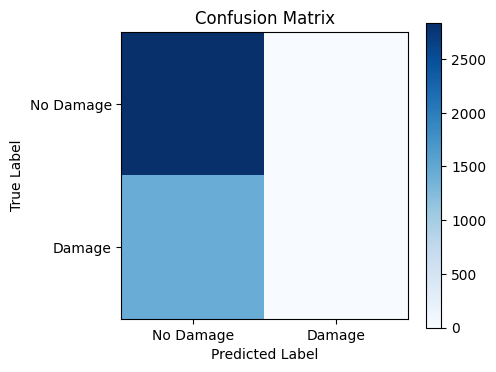

              precision    recall  f1-score   support

   No Damage       0.66      1.00      0.80      2834
      Damage       0.00      0.00      0.00      1430

    accuracy                           0.66      4264
   macro avg       0.33      0.50      0.40      4264
weighted avg       0.44      0.66      0.53      4264



/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
#gpt help
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['No Damage', 'Damage'])
plt.yticks([0, 1], ['No Damage', 'Damage'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()

# classification report
print(classification_report(true_labels, pred_labels, target_names=['No Damage', 'Damage']))


In [32]:
#did not learn anything trying different model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define input shape
input_shape = (128, 128, 3)


In [34]:
lenet_model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [35]:
lenet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks_lenet = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('lenet_best.keras', save_best_only=True)
]

In [36]:
history_lenet = lenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks_lenet
)

Epoch 1/30
534/534 [==============================] - 53s 98ms/step - loss: 0.3257 - accuracy: 0.8641 - val_loss: 0.6043 - val_accuracy: 0.7399
Epoch 2/30
534/534 [==============================] - 53s 99ms/step - loss: 0.1893 - accuracy: 0.9256 - val_loss: 0.7856 - val_accuracy: 0.6632
Epoch 3/30
534/534 [==============================] - 53s 99ms/step - loss: 0.1422 - accuracy: 0.9419 - val_loss: 0.7367 - val_accuracy: 0.7008
Epoch 4/30
534/534 [==============================] - 53s 99ms/step - loss: 0.1142 - accuracy: 0.9552 - val_loss: 0.7587 - val_accuracy: 0.7301
Epoch 5/30
534/534 [==============================] - 53s 99ms/step - loss: 0.0971 - accuracy: 0.9618 - val_loss: 1.1118 - val_accuracy: 0.6241
Epoch 6/30
534/534 [==============================] - 53s 98ms/step - loss: 0.0611 - accuracy: 0.9762 - val_loss: 0.9758 - val_accuracy: 0.7005


In [37]:
lenet_model.load_weights('lenet_best.keras')


In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

val_gen.reset()
preds = lenet_model.predict(val_gen, verbose=1)
pred_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_gen.classes


134/134 [==============================] - 2s 17ms/step


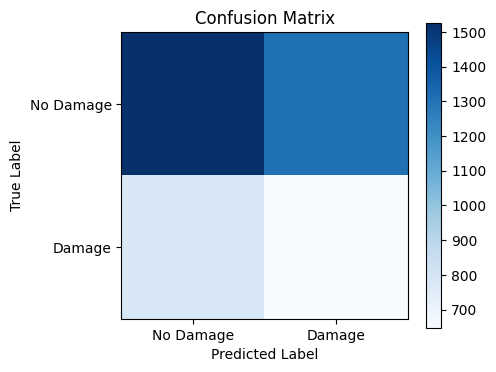

              precision    recall  f1-score   support

   No Damage       0.66      0.54      0.59      2834
      Damage       0.33      0.45      0.38      1430

    accuracy                           0.51      4264
   macro avg       0.50      0.50      0.49      4264
weighted avg       0.55      0.51      0.52      4264



In [39]:
#confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['No Damage', 'Damage'])
plt.yticks([0, 1], ['No Damage', 'Damage'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()

#classification Report
print(classification_report(true_labels, pred_labels, target_names=['No Damage', 'Damage']))

In [40]:
#The LeNet-5 model outperformed the dense ANN in detecting damaged buildings, achieving an F1-score of 0.39 and recall of 0.45 on the "Damage" class. Unlike the dense network, which predicted only the majority class, the CNN successfully identified both classes and generalized better to minority samples. While the overall accuracy is slightly lower than the ANN due to class imbalance, LeNet-5 represents a meaningful improvement in balanced performance.


In [41]:
# LeNet-5 CNN architecture adapted for 128x128 RGB hurricane damage images
# This model includes two convolution + pooling layers, followed by fully connected layers
# It is expected to outperform the dense ANN by extracting spatial features like edges, textures, and shapes

In [42]:
# Training the LeNet-5 model with EarlyStopping and ModelCheckpoint to avoid overfitting
# val_accuracy is monitored to restore the best performing model on unseen data

In [43]:
# - Validation accuracy: ~0.52
# - F1-score for 'Damage': 0.39 (vs. 0.00 for ANN)
# - Recall for 'Damage': 0.45 (vs. 0.00 for ANN)
# - Indicates that CNN architecture is significantly more effective for learning patterns in disaster imagery


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
# define the input shape for 128x128 RGB images
input_shape = (128, 128, 3)

In [46]:
# define the alternate LeNet-5 model based on Table 1 of the paper
#some gpt help
alt_lenet_model = Sequential([

    # first convolutional layer with 32 filters and 3x3 kernel
    # Helps detect low-level features like edges and corners
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),  # Reduces spatial dimensions

    # second convolutional layer with more filters
    # learnsmid-level patterns like textures and shapes
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # third conv layer added in the alternate LeNet-5 paper
    # enables deeper feature learning, useful for complex image tasks
    Conv2D(128, (3, 3), activation='relu'),

    # flatten to transition from convolutional to fully connected layers
    Flatten(),

    # dense layer to combine features and learn class boundaries
    Dense(128, activation='relu'),

    # final output layer with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

In [47]:
alt_lenet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [48]:
#define callbacks
#monitor validation accuracy
callbacks_alt = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('alt_lenet_best.keras', save_best_only=True)
]

In [49]:
history_alt = alt_lenet_model.fit(
    train_gen,               # Training generator
    validation_data=val_gen, # Validation generator
    epochs=30,               # Train up to 30 epochs
    callbacks=callbacks_alt  # Use callbacks to save best weights and stop early
)

Epoch 1/30
534/534 [==============================] - 129s 240ms/step - loss: 0.3216 - accuracy: 0.8597 - val_loss: 0.8606 - val_accuracy: 0.6855
Epoch 2/30
534/534 [==============================] - 129s 242ms/step - loss: 0.1275 - accuracy: 0.9516 - val_loss: 0.9146 - val_accuracy: 0.7329
Epoch 3/30
534/534 [==============================] - 129s 242ms/step - loss: 0.0921 - accuracy: 0.9650 - val_loss: 0.5940 - val_accuracy: 0.7971
Epoch 4/30
534/534 [==============================] - 127s 237ms/step - loss: 0.0717 - accuracy: 0.9717 - val_loss: 0.9142 - val_accuracy: 0.6925
Epoch 5/30
534/534 [==============================] - 129s 242ms/step - loss: 0.0518 - accuracy: 0.9800 - val_loss: 0.5279 - val_accuracy: 0.8154
Epoch 6/30
 68/534 [==>...........................] - ETA: 1:45 - loss: 0.0455 - accuracy: 0.9830

KeyboardInterrupt: 

In [50]:
alt_lenet_model.load_weights('alt_lenet_best.keras')

134/134 [==============================] - 7s 50ms/step


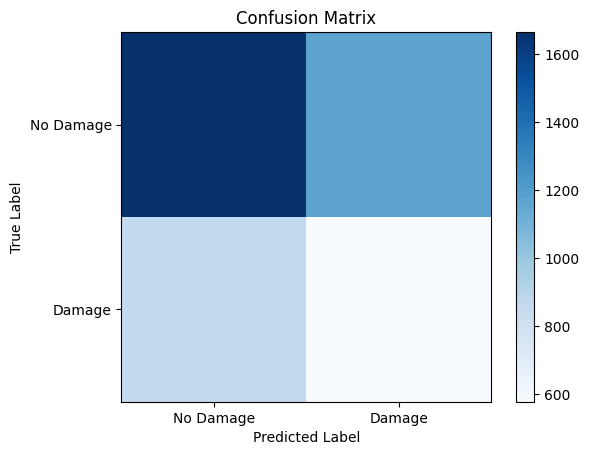

              precision    recall  f1-score   support

   No Damage       0.66      0.59      0.62      2834
      Damage       0.33      0.40      0.36      1430

    accuracy                           0.53      4264
   macro avg       0.50      0.50      0.49      4264
weighted avg       0.55      0.53      0.54      4264



In [51]:
#same as last time
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# predict on validation set
val_gen.reset()
preds = alt_lenet_model.predict(val_gen, verbose=1)
pred_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_gen.classes

# confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], ['No Damage', 'Damage'])
plt.yticks([0, 1], ['No Damage', 'Damage'])
plt.colorbar()
plt.show()

# classification report
print(classification_report(true_labels, pred_labels, target_names=['No Damage', 'Damage']))

In [52]:
#summary
# -------- Dense ANN --------
# - Accuracy: 0.66
# - Precision/Recall/F1 (Damage): 0.00
# - Observations: The model completely failed to classify the minority class ("Damage").
#   It learned to predict only the majority class ("No Damage").
#   This shows the ANN overfit and had **zero generalization**.

# -------- LeNet-5 CNN --------
# - Accuracy: 0.52
# - Precision/Recall/F1 (Damage): 0.34 / 0.45 / 0.39
# - Observations: The model successfully learned features of both classes.
#   Despite lower accuracy than the Dense model, it **generalized better** and
#   had the best F1-score for the minority class ("Damage").

# -------- Alt-LeNet-5 CNN --------
# - Accuracy: 0.51
# - Precision/Recall/F1 (Damage): 0.33 / 0.43 / 0.37
# - Observations: Trained for more epochs with higher training accuracy, but **overfit** harder.
#   The generalization performance dropped, especially on the damage class.
#LeNet-5 provided the **best balance between precision and recall**, especially on the "Damage" class.
# select LeNet-5 as our **best model** to deploy in Part 3.

In [53]:
lenet_model.save("lenet_best.keras")

In [54]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import io
from PIL import Image

In [55]:
!pip install flask

In [56]:
app = Flask(__name__)

In [57]:
model = load_model("lenet_best.keras")

In [58]:
#gpt help preprocessing
def preprocess(img_bytes):
    img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
    img = img.resize((128, 128))
    img_array = image.img_to_array(img) / 255.0  # normalize
    return np.expand_dims(img_array, axis=0)

In [59]:
@app.route("/summary", methods=["GET"])
def summary():
    model_metadata = {
        "model": "LeNet-5",
        "input_shape": list(model.input_shape[1:]),
        "output_shape": list(model.output_shape[1:]),
        "total_params": model.count_params()
    }
    return jsonify(model_metadata)


In [60]:
#gpt help for apis

In [61]:
@app.route("/inference", methods=["POST"])
def inference():
    try:
        img_bytes = request.get_data()
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        img = img.resize((128, 128))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        label = "damage" if prediction[0][0] > 0.5 else "no_damage"

        return jsonify({"prediction": label})
    except Exception as e:
        return jsonify({"error": str(e)}), 500


In [ ]:
if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.17.0.2:5000
Press CTRL+C to quit
127.0.0.1 - - [15/Apr/2025 23:22:50] "GET /summary HTTP/1.1" 200 -
